# E-Mini S&P500で日足データで上昇下降予測

ラリー本の、「高値かその付近で引けた翌日に上昇しやすい」という「真実」を検証する。

## 結果
これは真実ではないかもしれない。

In [43]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import scipy
import scipy.stats as st
import statsmodels.stats.anova as anova
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import datetime as dt
import locale

from finalib import finalib as fl

# 月や曜日を英語で取得するためこの設定をしておく
locale.setlocale(locale.LC_TIME, 'en_US.UTF-8')

'en_US.UTF-8'

In [2]:
# 日足データ
base_dir = 'data/e-mini-sp500-200530'
df_raw = pd.read_csv(f'{base_dir}/e-mini-sp500-daily.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5729 entries, 0 to 5728
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    5729 non-null   object 
 1   Time    5729 non-null   object 
 2   Open    5729 non-null   float64
 3   High    5729 non-null   float64
 4   Low     5729 non-null   float64
 5   Close   5729 non-null   float64
 6   Vol     5729 non-null   int64  
 7   OI      5729 non-null   int64  
dtypes: float64(4), int64(2), object(2)
memory usage: 358.2+ KB


In [27]:
# 過去N足分まで見れるデータにする

# 何足分見るか
N_BARS = 10

df = fl.make_nbars(df_raw, N_BARS, cols=['Open', 'High', 'Low', 'Close', 'Vol', 'OI'])
#fl.make_nbars(df_raw[:21], 10)
df.head(3)

,Date,Time,Open10,High10,Low10,Close10,Vol10,OI10,Open9,High9,...,Low1,Close1,Vol1,OI1,Open0,High0,Low0,Close0,Vol0,OI0
0,09/25/1997,17:00,1071.25,1082.25,1062.75,1068.50,11825,2909,1070.50,1089.00,...,1104.5,1106.00,14580.0,6194.0,1106.25,1110.0,1098.00,1099.25,14114.0,6132.0
1,09/26/1997,17:00,1070.50,1089.00,1066.00,1071.25,9759,4059,1086.00,1092.25,...,1098.0,1099.25,14114.0,6132.0,1099.00,1109.0,1099.00,1106.00,12049.0,5666.0
2,09/29/1997,17:00,1086.00,1092.25,1081.50,1083.75,8551,3818,1083.75,1112.50,...,1099.0,1106.00,12049.0,5666.0,1105.75,1117.0,1102.75,1114.50,11104.0,5722.0


In [28]:
# 値動き指標を追加

# イントラバーの値動き
for i in range(N_BARS+1):
    df[f'CODiff{i}'] = df[f'Close{i}'] - df[f'Open{i}'] # 終値 - 始値
    df[f'HLDiff{i}'] = df[f'High{i}'] - df[f'Low{i}'] # 高値 - 安値
    df[f'HCDiff{i}'] = df[f'High{i}'] - df[f'Close{i}'] # 高値 - 終値
    df[f'OLDiff{i}'] = df[f'Open{i}'] - df[f'Low{i}'] # 始値 - 安値
    df[f'CLDiff{i}'] = df[f'Close{i}'] - df[f'Low{i}'] # 終値 - 安値
    
# 2足間の値動き
for i in range(N_BARS):
    df[f'CSlope{i}'] = df[f'Close{i}'] - df[f'Close{i+1}'] # ある日の終値 - 前日の終値
    #df[f'OSlope{i}'] = df[f'Open{i}'] - df[f'Open{i+1}'] # ある日の始値 - 前日の始値
    #df[f'LSlope{i}'] = df[f'Low{i}'] - df[f'Low{i+1}'] # ある日の安値 - 前日の安値
    #df[f'HSlope{i}'] = df[f'High{i}'] - df[f'High{i+1}'] # ある日の高値 - 前日の高値
    #df[f'VSlope{i}'] = df[f'Vol{i}'] - df[f'Vol{i+1}'] # ある日の出来高 - 前日の出来高
    df[f'HCSlope{i}'] = df[f'High{i}'] - df[f'Close{i+1}'] # ある日の高値 - 前日の終値
    df[f'CLSlope{i}'] = df[f'Close{i+1}'] - df[f'Low{i}'] # ある日の前日の終値 - ある日の安値

# 前処理

- 年単位の分析もするため、半端になっている最初の年（1997）と最後の年（2020）は除外する
- 始めの数年間は直近と比べると出来高が非常に小さく流動性が低いが、今は日足での値動きに注目しているため問題ないとみなして、それらのデータを除外しない

だから、1998年初めから2019年終わりまでのデータを使用する。

In [29]:
# DateをDatetime型にする
df['Date'] = df['Date'].map(lambda s: dt.datetime.strptime(s, '%m/%d/%Y').date())

# 最初の年（1997）と最後の年（2020）は1年分のデータがないから除外する
# 始まりの年と終わりの年（終わりは含まない）
s_year = 1998
e_year = 2020

df = df[(df['Date'] >= dt.date(s_year,1,1)) & (df['Date'] < dt.date(e_year,1,1))]
df = df.reset_index(drop=True)
df.info()
print('\n始めのデータ\n', df[:1])
print('\n終わりのデータ\n', df[-1:])

# 年列を入れる
df['year'] = df['Date'].map(lambda date: date.year)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5548 entries, 0 to 5547
Columns: 153 entries, Date to CLSlope9
dtypes: float64(149), int64(2), object(2)
memory usage: 6.5+ MB

始めのデータ
          Date   Time  Open10   High10    Low10  Close10  Vol10  OI10   Open9  \
0  1998-01-02  17:00  1122.5  1130.25  1116.75   1117.5   9562  4611  1117.5   

     High9  ...  CLSlope6  CSlope7  HCSlope7  CLSlope7  CSlope8  HCSlope8  \
0  1118.75  ...      18.5     5.25      11.0       9.0    -7.75      -0.5   

   CLSlope8  CSlope9  HCSlope9  CLSlope9  
0      30.0   -10.25      1.25     14.75  

[1 rows x 153 columns]

終わりのデータ
             Date   Time   Open10   High10    Low10  Close10    Vol10     OI10  \
5547  2019-12-31  17:00  3168.25  3191.25  3165.75  3187.25  1973586  2015350   

        Open9    High9  ...  CLSlope6  CSlope7  HCSlope7  CLSlope7  CSlope8  \
5547  3185.25  3192.25  ...      3.25     12.5      14.5      4.75     3.75   

      HCSlope8  CLSlope8  CSlope9  HCSlope9  CLSlope9  


# 高値かその付近で引けた翌日に上昇するか

- ラリーの本の15章より
- 「高値かその付近で引けた」を終値が真の値幅の上部X%以内であることと定義する

真の値幅（TR)とは
- 高値 - 安値
- 高値 - 前日終値
- 前日終値 - 安値

のうち最も大きいもの

## 結果
- 高値で引けた日については、そもそも発生率が低すぎるため、調査対象外
- 高値かその付近で引けた日の場合は、「その付近」の定義次第で発生率は変わる
    - 「高値かその付近」を「終値が（高値 - 真の値幅 * X）以上」と定義し、X=0.1としてみた
        - この時、発生率は15.6%であり、年によって全く発生しないなどということもないため、現実的
        - しかし、翌日の値動き平均は`-0.45`だった。
        - また翌日の上昇日割合は51.3%だった。
        - したがって、「高値かその付近で引けた翌日に上昇する」という仮説は全く支持されない。
- 上の結果は、「高値かその付近」を定義してしまっているため、その定義を変えたときに結果がどう変わるかは各定義で試してみなければわからない。これだと効率が悪いため、調査内容を「前日が上昇日だった場合に、高値付近で引けるほど翌日上昇しやすいかどうか」とした。つまり（高値 - 終値）に対して翌日の（終値 - 始値）をプロットする。またこの時相関係数が負の値になることを期待する。
    - 結果、相関はほぼなく、相関係数は0.024だった。

In [30]:
# まずは高値で引けた場合で見てみる
# p(当日上昇 | 前日高値で引ける)
df_last_high = df[df['Close1'] == df['High1']]
df_last_high.shape[0]
print(f'高値で引けた日 / 全日数 = {df_last_high.shape[0]} / {df.shape[0]}')
print(f'高値で引けた日の割合 = {df_last_high.shape[0] / df.shape[0]}')

高値で引けた日 / 全日数 = 17 / 5548
高値で引けた日の割合 = 0.0030641672674837778


In [31]:
# 真の値幅（TR)を作成
for i in range(N_BARS - 1):
    df[f'TR{i}'] = df[[f'HCSlope{i}', f'CLSlope{i}', f'HLDiff{i}']].max(axis=1)

In [83]:
# 高値で引けた日の発生確率は低すぎるからこれを使うのは現実的でない
# よって高値かその付近で引けた日の翌日に上昇するかを検証する
# 条件としては、（上げて引けたこと）AND（高値かその付近で引けたこと）
# 「高値かその付近で引けたこと」を終値がTRの上部10%以内であることとする

# TRの上部何%にするか
TR_UPPER_RATIO = 0.1 # この数字*100でパーセンテージ

df_last_near_high = df[(df['CODiff1'] > 0) & (df['Close1'] >= df['High1'] - df['TR1'] * TR_UPPER_RATIO)]
print(f'高値かその付近で引けた日 / 全日数 = {df_last_near_high.shape[0]} / {df.shape[0]}')
print(f'高値かその付近で引けた日の割合 = {df_last_near_high.shape[0] / df.shape[0]}')

高値かその付近で引けた日 / 全日数 = 869 / 5548
高値かその付近で引けた日の割合 = 0.15663302090843548


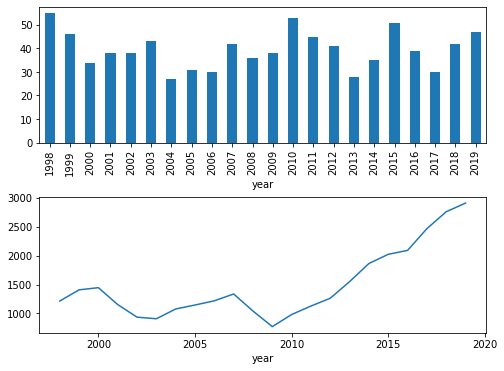

In [84]:
# 「高値かその付近で引けた日」の発生日について、年毎の日数を表示
# もし年毎に発生率が大きく違う場合は、年毎の損益にも大きく影響するため。
fig, ax = plt.subplots(2, 1, figsize=(8, 6))
df_last_near_high.groupby('year')['Date'].count().plot.bar(ax=ax[0])
df.groupby('year')['Close0'].mean().plot(ax=ax[1])
plt.subplots_adjust(hspace=0.4)

# ばらつきはあるけど、全然発生しない年などはないから、毎年リターンを期待する戦略を開発することは可能だろう
# 毎年の終値の平均も一緒にプロットした限りだと、トレンドとの相関はとくに見られない

高値かその付近で引けた翌日の値動きの平均 = -0.4562715765247411
高値かその付近で引けた翌日に上昇した日 / 全日数 = 446 / 869
高値かその付近で引けた翌日に上昇した日の割合 = 0.5132336018411968


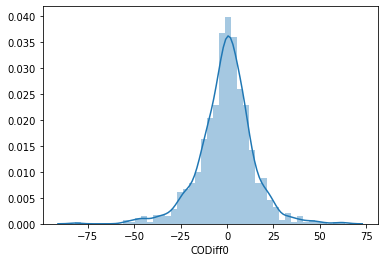

In [85]:
# 前日高値かその付近で引けた場合の、当日の値動き（終値 - 始値）分布を可視化
sns.distplot(df_last_near_high['CODiff0'])

print(f"高値かその付近で引けた翌日の値動きの平均 = {df_last_near_high['CODiff0'].mean()}")
print(f"高値かその付近で引けた翌日に上昇した日 / 全日数 = {df_last_near_high[df_last_near_high['CODiff0'] > 0].shape[0]} / {df_last_near_high.shape[0]}")
print(f"高値かその付近で引けた翌日に上昇した日の割合 = {df_last_near_high[df_last_near_high['CODiff0'] > 0].shape[0] / df_last_near_high.shape[0]}")

# これを見る限り、前日高値かその付近で引けたとしても、当日上昇する傾向は特に見られない

（高値 - 終値）と翌日の（終値 - 始値）の相関係数 = 0.02428913490620477


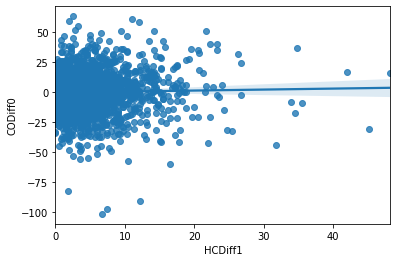

In [88]:
# やるべきことは少し違った。
# 前日が上げて引けた日の場合に、前日の（高値 - 終値）に対して当日の値動き（終値 - 始値）を可視化すべきだった。
df_last_up = df[df['CODiff1'] > 0]
sns.regplot('HCDiff1', 'CODiff0', data=df_last_up)

# df
print(f"（高値 - 終値）と翌日の（終値 - 始値）の相関係数 = {df_last_up.corr().loc['HCDiff1', 'CODiff0']}")